In [81]:
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QWidget, QCalendarWidget, QPushButton, QMessageBox, QLabel, QHBoxLayout, QSizePolicy, QTableWidget, QTableWidgetItem, QHeaderView
from PyQt5.QtCore import QLocale, Qt, QDate
from PyQt5.QtGui import QColor, QFont
from datetime import datetime
import sys

In [82]:
# คลาสสำหรับการจัดการกับฐานข้อมูล SQLite
class DatabaseManager:
    def __init__(self, db_name='Crown_Counting.db'):
        self.conn = sqlite3.connect(db_name)
        self.cursor = self.conn.cursor()
        self.create_table()

    # ฟังก์ชันสำหรับสร้างตารางถ้ายังไม่มี
    def create_table(self):
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS records (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                date TEXT,
                time TEXT,
                people_count INTEGER,
                image_path TEXT
            )
        ''')
        self.conn.commit()

    # ฟังก์ชันเพิ่มข้อมูลลงในตาราง
    def insert_record(self, date, time, people_count, image_path):
        self.cursor.execute('''
            INSERT INTO records (date, time, people_count, image_path)
            VALUES (?, ?, ?, ?)
        ''', (date, time, people_count, image_path))
        self.conn.commit()

    # ฟังก์ชันลบข้อมูลตาม id
    def delete_record(self, record_id):
        self.cursor.execute('''
            DELETE FROM records WHERE id = ?
        ''', (record_id,))
        self.conn.commit()

    def fetch_all_dates_with_data(self):
        query = "SELECT DISTINCT date FROM records"
        self.cursor.execute(query)
        return [row[0] for row in self.cursor.fetchall()]

    # ฟังก์ชันดึงข้อมูลตามวันที่
    def fetch_data_by_date(self, date):
        query = "SELECT * FROM records WHERE date = ?"
        self.cursor.execute(query, (date,))
        return self.cursor.fetchall()
    
    def Pie_Chart_fetch_data_by_date(self, date):
        query = '''
            SELECT time, SUM(people_count) as total_count
            FROM records
            WHERE date = ?
            GROUP BY time
        '''
        self.cursor.execute(query, (date,))
        results = self.cursor.fetchall()  # Get the results as a list of tuples

        # Convert to a dictionary
        return {time: total_count for time, total_count in results}

    # ปิดการเชื่อมต่อฐานข้อมูล
    def close(self):
        self.conn.close()

In [83]:
# db_manager = DatabaseManager()

# # เพิ่มข้อมูลใหม่ลงในฐานข้อมูล
# db_manager.insert_record('2024-09-29', '12:00', 16, '/path/to/image.jpg')
# db_manager.insert_record('2024-09-29', '13:00', 14, '/path/to/image.jpg')
# db_manager.insert_record('2024-09-29', '14:00', 13, '/path/to/image.jpg')
# db_manager.insert_record('2024-09-29', '15:00', 16, '/path/to/image.jpg')
# db_manager.insert_record('2024-09-29', '16:00', 19, '/path/to/image.jpg')
# db_manager.insert_record('2024-09-29', '17:00', 18, '/path/to/image.jpg')
# db_manager.insert_record('2024-09-30', '12:00', 15, '/path/to/image.jpg')
# db_manager.insert_record('2024-09-30', '13:00', 14, '/path/to/image.jpg')
# db_manager.insert_record('2024-09-30', '14:00', 16, '/path/to/image.jpg')
# db_manager.insert_record('2024-09-30', '15:00', 16, '/path/to/image.jpg')
# db_manager.insert_record('2024-09-30', '16:00', 17, '/path/to/image.jpg')
# db_manager.insert_record('2024-09-30', '17:00', 12, '/path/to/image.jpg')

In [84]:
class GraphPlotter:
    def __init__(self, canvas):
        self.canvas = canvas

    def plot_pie_chart(self, data):
        self.canvas.figure.clear()
        ax = self.canvas.figure.add_subplot(121)  # First subplot for pie chart

        categories = list(data.keys())
        values = list(data.values())

        # Pie chart
        ax.pie(values, labels=categories, autopct='%1.1f%%', startangle=90)
        ax.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
        ax.set_title('Percentage of Counts per Time Slot')

    def plot_line_chart(self, data):
        ax = self.canvas.figure.add_subplot(122)  # Second subplot for line chart
        categories = list(data.keys())
        values = list(data.values())

        # Line chart
        ax.plot(categories, values, marker='o')
        ax.set_title('People Count Over Time')
        ax.set_xlabel('Time')
        ax.set_ylabel('People Count')
        ax.grid(True)

    def draw(self):
        self.canvas.draw()

In [85]:
class CustomCalendarWidget(QCalendarWidget):
    def __init__(self, db_manager, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.db_manager = db_manager

    def paintCell(self, painter, rect, date):
        super().paintCell(painter, rect, date)
        formatted_date = date.toString("yyyy-MM-dd")
        if formatted_date in self.db_manager.fetch_all_dates_with_data():
            circle_color = QColor("red")
            circle_radius = 3
            circle_x = int(rect.x() + rect.width() / 2)
            padding = 7
            circle_y = int(rect.y() + rect.height() - padding)
            painter.setBrush(circle_color)
            painter.drawEllipse(circle_x - circle_radius, circle_y - circle_radius, 
                                circle_radius * 2, circle_radius * 2)

In [86]:
def format_date(date_str, time_str):
    # แปลงจากสตริงเป็นวันที่
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")
    # แปลงกลับเป็นสตริงในรูปแบบที่ต้องการ
    formatted_date = date_obj.strftime("%B %d %Y at")
    return f"{formatted_date} {time_str}"

In [87]:
class HoverButton(QPushButton):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.setStyleSheet("background-color: #4CAF50; color: white; border: none; border-radius: 5px; padding: 10px;")
        self.setCursor(Qt.PointingHandCursor)

    def enterEvent(self, event):
        self.setStyleSheet("background-color: #45a049; color: white; border: none; border-radius: 5px; padding: 10px;")
        super().enterEvent(event)

    def leaveEvent(self, event):
        self.setStyleSheet("background-color: #4CAF50; color: white; border: none; border-radius: 5px; padding: 10px;")
        super().leaveEvent(event)

In [88]:
class CalendarApp(QMainWindow):
    def __init__(self):
        super().__init__()

        self.setWindowTitle('Crown Counting System')
        self.setGeometry(100, 100, 1700, 950)

        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)

        layout = QVBoxLayout()
        layout.setSpacing(0)
        layout.setContentsMargins(0, 0, 0, 0)

        # Database Manager
        self.db_manager = DatabaseManager()
        
        # Custom Calendar Widget
        self.calendar = CustomCalendarWidget(self.db_manager, self)
        self.calendar.setLocale(QLocale(QLocale.English, QLocale.UnitedStates))
        self.calendar.setGridVisible(True)
        self.calendar.setFixedHeight(350)

        layout.addWidget(self.calendar)

        # Button to show graphs
        self.plot_button = HoverButton('Show Graphs')
        self.plot_button.clicked.connect(self.show_graph)
        self.plot_button.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Fixed)
        layout.addWidget(self.plot_button)

        # Horizontal layout for graph and labels
        self.labels_and_canvas_layout = QHBoxLayout()

        # Matplotlib figure and canvas
        self.figure = plt.figure(figsize=(6, 4))
        self.canvas = FigureCanvas(self.figure)
        self.canvas.setVisible(False)

        # Graph frame
        self.graph_frame = QWidget()
        graph_layout = QVBoxLayout(self.graph_frame)
        graph_layout.addWidget(self.canvas)
        self.graph_frame.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
        self.graph_frame.setMinimumSize(600, 400)
        self.labels_and_canvas_layout.addWidget(self.graph_frame)

        # Vertical layout for labels
        self.labels_layout = QVBoxLayout()
        self.labels_layout.setContentsMargins(0, 0, 20, 0)

        # Number of people label
        self.number_frame = QWidget()
        self.number_frame.setStyleSheet("background-color: white; padding: 5px")
        self.number_frame.setVisible(False)

        number_layout = QVBoxLayout(self.number_frame)
        number_layout.setContentsMargins(5, 5, 10, 5)

        # Title for Number of People
        self.number_of_people_title = QLabel("Number of People")
        self.number_of_people_title.setAlignment(Qt.AlignCenter)
        self.number_of_people_title.setFont(QFont('Arial', 10))
        number_layout.addWidget(self.number_of_people_title)

        # Label for showing the actual number of people
        self.number_of_people_value = QLabel("0")  # Initialize with 0
        self.number_of_people_value.setAlignment(Qt.AlignCenter)
        self.number_of_people_value.setFont(QFont('Arial', 30, QFont.Bold))  # Larger font for the number
        self.number_of_people_value.setStyleSheet("color: #4CAF50")  # Set text color to green
        number_layout.addWidget(self.number_of_people_value)

        self.number_frame.setFixedSize(420, 150)
        self.labels_layout.addWidget(self.number_frame)

        # Create QTableWidget for displaying records
        self.data_table = QTableWidget()
        self.data_table.setColumnCount(2)
        self.data_table.setHorizontalHeaderLabels(["Date", "People"])
        self.data_table.setVisible(False)
        self.data_table.setFixedSize(420, 370)
        self.labels_layout.addWidget(self.data_table)  # Add table directly to labels layout

        # Add labels layout to the horizontal layout
        self.labels_and_canvas_layout.addLayout(self.labels_layout)

        # Add the labels and canvas layout to the main layout
        layout.addLayout(self.labels_and_canvas_layout)

        self.central_widget.setLayout(layout)
        self.graph_plotter = GraphPlotter(self.canvas)

    def show_graph(self):
        selected_date = self.calendar.selectedDate().toString("yyyy-MM-dd")
        pie_data = self.db_manager.Pie_Chart_fetch_data_by_date(selected_date)

        if pie_data:
            self.graph_plotter.plot_pie_chart(pie_data)
            self.graph_plotter.plot_line_chart(pie_data)
            self.graph_plotter.draw()

            total_people = sum(pie_data.values())
            self.number_of_people_value.setText(str(total_people))  # Update the label with the total number

            # Populate the table with data
            records = self.db_manager.fetch_data_by_date(selected_date)
            self.populate_table(records)

            # Make frames visible
            self.number_frame.setVisible(True)
            self.data_table.setVisible(True)
            self.canvas.setVisible(True)
        else:
            QMessageBox.warning(self, "Caution", f"No data available on date : {selected_date}.", QMessageBox.Ok)

    
    def populate_table(self, records):
        self.data_table.setRowCount(len(records))  # Set the number of rows based on records
        for row_index, record in enumerate(records):
            formatted_date = format_date(record[1], record[2])  # Format the date
            self.data_table.setItem(row_index, 0, QTableWidgetItem(formatted_date))  # Set date in column 0

            # Set the people count
            people_count = record[3]
            people_item = QTableWidgetItem(str(people_count))  # Create the item for people count
            people_item.setTextAlignment(Qt.AlignCenter)  # Center-align the text
            self.data_table.setItem(row_index, 1, people_item)  # Set the centered item in column 1

        # Set specific widths for columns
        self.data_table.setColumnWidth(0, 260)  # Adjust the width of the Date column
        self.data_table.setColumnWidth(1, 140)  # Adjust the width of the People column

    def closeEvent(self, event):
        self.db_manager.close()
        event.accept()


In [89]:
# ฟังก์ชันหลักสำหรับการรันแอปพลิเคชัน PyQt
def run_app():
    app = QApplication(sys.argv)
    window = CalendarApp()
    window.show()
    sys.exit(app.exec_())


SystemExit: 0

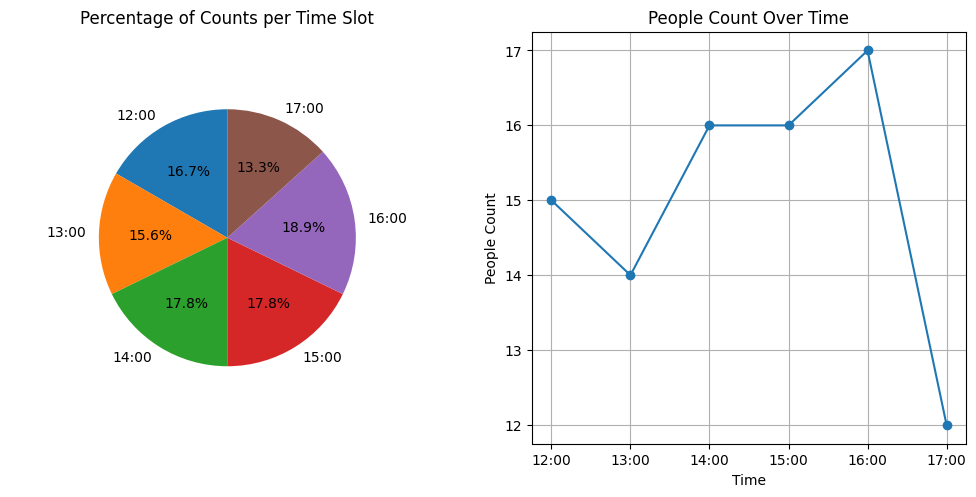

In [90]:
run_app()